<a href="https://colab.research.google.com/github/DavMLPath/PhD-Theses/blob/main/Banking_Stability_Modeling_1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
from statistics import mean
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from datetime import date, timedelta



# **Loading data from drive, doing feature selection/transformation**

In [ ]:
#importing libs for the model
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# #independent variables

x=pd.read_excel('/content/drive/My Drive/Dissertation/Data/factors_all_final.xlsx', sheet_name='Factors')

x.index=x['Date']
x.drop(columns=['Date'], inplace=True)
# x['Mortgage loans'] = np.log(x['Mortgage loans'])
x['Mortgage loans']=np.log(x['Mortgage loans'])

In [ ]:
x.columns.values

array(['Inflow (trade)', 'Inflow (non-trade)', 'Outflow (trade)',
       'Outflow (non-trade)', 'Reserve position in the IMF',
       'Foreign Exchange Reserves', 'Medium term government bond yield',
       'Government bond yield (<365 days)',
       'Government’s net domestic assets (million AMD)',
       'Banks’ net domestic assets (million AMD)',
       'Net other assets (million AMD)', 'CPI',
       'CPI-Consumer goods (including alcoholic beverages and tobacco)',
       'CPI-Non-consumer goods', 'CPI-Services',
       'Economic activity index',
       'Inv. comp. Sales and purchase transactions (million AMD)',
       'Inv. comp. Repo transactions (million AMD)',
       'Normative capital ratio to risk-weighted assets',
       'Tier 1 capital ratio to risk-weighted assets',
       'Non-performing loans ratio to total loans', 'Return on assets',
       'Return on capital', 'High liquidity assets ratio to total assets',
       'High liquidity assets ratio to demand liabilities',
    

##List of factors with growth rate

In [ ]:

#ROA+(equity/assets))/sd(ROA)

to_change=[
'Industry Loans'
,'Demand deposits in AMD (million AMD)'
,'Time deposits in AMD (million AMD)'
,'Foreign currency deposits (million AMD)'
,'Inv. comp. Sales and purchase transactions (million AMD)'
,'Construction loans'
,'Agriculture loans'
#,'Accumulated profit (million AMD)'
,'Total capital (million AMD)'
,'Consumer loans loans'
#,'Repo agreements (million AMD)'
,'Mortgage loans'
,'Trade loans'
,'Total liabilities (million AMD)'
,'High liquidity assets ratio to demand liabilities'
,'Russian Ruble/AMD'
,'Euro/AMD'
,'US Dollar/AMD'
,'Normative capital ratio to risk-weighted assets'
,'High liquidity assets ratio to total assets'
,'CPI'
]

for i in to_change:
  x[i]=x[i].pct_change()


##Definin factors to remove/combine

In [ ]:
x['Dolarisation_avg']=(x['D1']+x['D2']+x['D3']+x['D5']+x['D4'])/4
x['Gov. bond yealds']=(x['Medium term government bond yield']+x['Government bond yield (<365 days)'])/2
x['fc-loans']=x["Industry Loans (fc)"]+x["Agriculture loans (fc)"]+x["Construction loans (fc)"]+x["Trade loans (fc)"]+x["Service sector loans (fc)"]+x["Consumer loans loans (fc)"]+x["Others loans (fc)"]
x.drop(columns=['Repo agreements (million AMD)','Accumulated profit (million AMD)','Total assets (million AMD)','Return on assets','Industry Loans (fc)', 'Agriculture loans (fc)', 'Construction loans (fc)', 'Trade loans (fc)', 'Service sector loans (fc)', 'Consumer loans loans (fc)', 'Others loans (fc)', 'D1', 'D2', 'D3', 'D4', 'D5','Medium term government bond yield','Government bond yield (<365 days)'], inplace=True)
x.drop(columns=['British Pound Sterling/AMD', 'Iranian Rial/AMD','Tier 1 capital ratio to risk-weighted assets','CPI-Consumer goods (including alcoholic beverages and tobacco)','CPI-Non-consumer goods','Swiss Franc/AMD', 'Georgian Lari/AMD'], inplace=True)

x['Dolarisation_avg']=x['Dolarisation_avg'].pct_change()
x.drop('2012-12-01', inplace=True)


In [ ]:
x.columns.values

array(['Inflow (trade)', 'Inflow (non-trade)', 'Outflow (trade)',
       'Outflow (non-trade)', 'Reserve position in the IMF',
       'Foreign Exchange Reserves',
       'Government’s net domestic assets (million AMD)',
       'Banks’ net domestic assets (million AMD)',
       'Net other assets (million AMD)', 'CPI', 'CPI-Services',
       'Economic activity index',
       'Inv. comp. Sales and purchase transactions (million AMD)',
       'Inv. comp. Repo transactions (million AMD)',
       'Normative capital ratio to risk-weighted assets',
       'Non-performing loans ratio to total loans', 'Return on capital',
       'High liquidity assets ratio to total assets',
       'High liquidity assets ratio to demand liabilities',
       'US Dollar/AMD', 'Euro/AMD', 'Russian Ruble/AMD',
       'Cash in circulation (million AMD)',
       'Demand deposits in AMD (million AMD)',
       'Time deposits in AMD (million AMD)',
       'Foreign currency deposits (million AMD)',
       'Total liabiliti

In [ ]:
y=pd.read_excel('/content/drive/My Drive/Dissertation/Data/factors_all_final.xlsx', sheet_name='Z-score(Y)')

# # x.columns=x.iloc[0,:]

y.index=y['Date']
y.drop(columns=['Date'], inplace=True)
y

,Z-score
Date,
2013-01-01,7.521965
2013-02-01,7.951818
2013-03-01,7.337288
2013-04-01,5.987805
2013-05-01,8.550364
...,...
2024-08-01,7.824952
2024-09-01,8.755918
2024-10-01,6.504123


In [ ]:
x_back=x.copy(deep=True)

In [ ]:
y_back=y.copy(deep=True)

## **Stationarity adjustments**


In [ ]:
#function for checking stationarity and returinig stationarized series
def check_stationarity(series):
  for i in range(0, 50):
      if i==0:
        dep_var = series
      else:
        dep_var= series - series.shift(i).fillna(0)
      result = adfuller(dep_var)
      adf_statistic = result[0]
      p_value = result[1]
      if float(("%.17f" % p_value).rstrip('0').rstrip('.'))<=0.05:
        break
  return i,("%.17f" % p_value).rstrip('0').rstrip('.'), dep_var
#      print("p-value:", ("%.17f" % p_value).rstrip('0').rstrip('.'))


In [ ]:
#choosing stationarity parameter for the dependent variable
a=check_stationarity(y['Z-score'])
y=a[2]
y

,Z-score
Date,
2013-01-01,7.521965
2013-02-01,0.429852
2013-03-01,-0.614530
2013-04-01,-1.349483
2013-05-01,2.562559
...,...
2024-08-01,0.994868
2024-09-01,0.930966
2024-10-01,-2.251795


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#creating dictionary with stationarised variables
dict_normalized=pd.DataFrame()
stationarity=[]
features=[]
levels=[]
for i in x:
  if i not in ['Date', 'Բանկային տոկոս']:
    x[i].fillna(0, inplace = True)
    dict_normalized[i]=check_stationarity(x[i])[2]
    #print(check_stationarity(x[i])[0]   )
    stationarity.append([i, check_stationarity(x[i])[0]])
    features.append(i)
    levels.append(check_stationarity(x[i])[0])
# dict_normalized

In [ ]:
print(len(features))
print(len(levels))
# pd.DataFrame({"name":features, "diff_level":levels})

44
44


In [ ]:
type(dict_normalized.std().values)

numpy.ndarray

In [ ]:
denormdf=pd.DataFrame({"name":features, "diff_level":levels})
denormdf.sort_values(by='diff_level', ascending=False)

,name,diff_level
40,bitcoin_price,5
39,Mortgage loans (fc),4
28,Foreign debt,3
22,Cash in circulation (million AMD),2
42,Gov. bond yealds,2
5,Foreign Exchange Reserves,1
7,Banks’ net domestic assets (million AMD),1
6,Government’s net domestic assets (million AMD),1
0,Inflow (trade),1
1,Inflow (non-trade),1


In [ ]:
#variables, that are not stationary after 3-rd lag, we will exclude from model
s_list=pd.DataFrame(stationarity, columns=["factor", "level"])
valid_factors=s_list['factor'][s_list['level'].astype(float)<=7]
invalid_factors=s_list['factor'][s_list['level'].astype(float)>7]
valid_factors

,factor
0,Inflow (trade)
1,Inflow (non-trade)
2,Outflow (trade)
3,Outflow (non-trade)
4,Reserve position in the IMF
5,Foreign Exchange Reserves
6,Government’s net domestic assets (million AMD)
7,Banks’ net domestic assets (million AMD)
8,Net other assets (million AMD)
9,CPI


In [ ]:
s_list[s_list['factor'].isin(invalid_factors)]

,factor,level


## **Defining X and Y**

In [ ]:
x=dict_normalized
len(x.columns.values)

44

In [ ]:
y=pd.DataFrame({'Z-score':y})

In [ ]:
denormdf=denormdf[denormdf['name'].isin(x.columns.values)]

In [ ]:
denormdf.sort_values(by='diff_level', ascending=False)

,name,diff_level
40,bitcoin_price,5
39,Mortgage loans (fc),4
28,Foreign debt,3
22,Cash in circulation (million AMD),2
42,Gov. bond yealds,2
5,Foreign Exchange Reserves,1
7,Banks’ net domestic assets (million AMD),1
6,Government’s net domestic assets (million AMD),1
0,Inflow (trade),1
1,Inflow (non-trade),1


## **checking multicolinearity**


**Lasso model for not lagged**



In [ ]:
x.corr()

,Inflow (trade),Inflow (non-trade),Outflow (trade),Outflow (non-trade),Reserve position in the IMF,Foreign Exchange Reserves,Government’s net domestic assets (million AMD),Banks’ net domestic assets (million AMD),Net other assets (million AMD),CPI,...,Service sector loans,Consumer loans loans,Mortgage loans,Others loans,Transport and communications loans (fc),Mortgage loans (fc),bitcoin_price,Dolarisation_avg,Gov. bond yealds,fc-loans
Inflow (trade),1.000000,0.293460,0.507220,0.208820,-0.014551,0.137261,0.098166,0.138123,0.126441,-0.088357,...,0.162275,-0.016430,0.333346,0.050402,-0.037776,-0.006857,-0.001425,-0.284902,0.016756,0.034937
Inflow (non-trade),0.293460,1.000000,0.258959,0.570080,0.093912,0.382040,0.174809,0.116534,0.167735,-0.236099,...,0.309707,0.043241,0.558717,0.305590,0.109939,0.159549,0.009872,-0.389460,0.150852,0.253476
Outflow (trade),0.507220,0.258959,1.000000,0.192759,0.045906,0.116301,0.105721,-0.027444,0.104754,-0.172617,...,0.054897,-0.002539,0.235713,0.011811,-0.138326,-0.030578,-0.058775,-0.100586,0.020912,0.083264
Outflow (non-trade),0.208820,0.570080,0.192759,1.000000,0.061872,0.334144,-0.036802,0.030590,0.143514,-0.082101,...,0.126874,0.126577,0.454795,0.161733,0.222676,0.190036,0.014516,-0.231328,0.157967,0.324278
Reserve position in the IMF,-0.014551,0.093912,0.045906,0.061872,1.000000,-0.029807,-0.000161,-0.096798,0.060151,-0.002414,...,-0.058827,-0.203081,-0.004083,-0.045441,-0.051957,-0.034987,-0.074320,0.161309,0.133222,0.048049
Foreign Exchange Reserves,0.137261,0.382040,0.116301,0.334144,-0.029807,1.000000,-0.469969,0.170362,0.291970,0.013305,...,0.487837,0.074968,0.154138,0.277551,0.254990,0.211402,-0.060551,-0.179909,0.382572,0.582302
Government’s net domestic assets (million AMD),0.098166,0.174809,0.105721,-0.036802,-0.000161,-0.469969,1.000000,-0.076457,-0.230156,-0.012418,...,-0.059254,-0.052869,0.165265,0.002105,-0.092670,-0.110725,-0.087831,-0.089827,-0.114296,-0.152149
Banks’ net domestic assets (million AMD),0.138123,0.116534,-0.027444,0.030590,-0.096798,0.170362,-0.076457,1.000000,-0.020718,0.113134,...,0.205644,0.029374,0.043854,-0.000888,0.041758,0.108622,0.118012,-0.112029,0.132873,0.199407
Net other assets (million AMD),0.126441,0.167735,0.104754,0.143514,0.060151,0.291970,-0.230156,-0.020718,1.000000,-0.074471,...,0.353732,0.010749,-0.072912,0.161959,0.251491,0.222996,-0.099578,-0.137596,0.386109,0.460950
CPI,-0.088357,-0.236099,-0.172617,-0.082101,-0.002414,0.013305,-0.012418,0.113134,-0.074471,1.000000,...,-0.025933,0.129268,-0.184825,0.072006,0.085026,-0.050316,-0.031690,0.211670,-0.142576,0.059089


In [ ]:
len(x.columns.values)

44

In [ ]:
# x.describe().loc['count']

In [ ]:
Highly_Correlated_column_name = {}
corr = x.corr().to_numpy()
column_names = x.columns
row_no = 0
for r in corr:
    col_no = 0
    for c in r:
        if (c>0.9 and c<1) or (c<-0.9 and c>-1):
            if column_names[row_no] in Highly_Correlated_column_name:
              if column_names[col_no] not in Highly_Correlated_column_name[column_names[row_no]]:
                Highly_Correlated_column_name[column_names[row_no]].append(column_names[col_no])
            else:
              Highly_Correlated_column_name[column_names[row_no]] = [column_names[col_no]]
            print(f"'{column_names[row_no]}', '{column_names[col_no]}', {c}")
        col_no+=1
    row_no += 1

In [ ]:
x.columns.values

array(['Inflow (trade)', 'Inflow (non-trade)', 'Outflow (trade)',
       'Outflow (non-trade)', 'Reserve position in the IMF',
       'Foreign Exchange Reserves',
       'Government’s net domestic assets (million AMD)',
       'Banks’ net domestic assets (million AMD)',
       'Net other assets (million AMD)', 'CPI', 'CPI-Services',
       'Economic activity index',
       'Inv. comp. Sales and purchase transactions (million AMD)',
       'Inv. comp. Repo transactions (million AMD)',
       'Normative capital ratio to risk-weighted assets',
       'Non-performing loans ratio to total loans', 'Return on capital',
       'High liquidity assets ratio to total assets',
       'High liquidity assets ratio to demand liabilities',
       'US Dollar/AMD', 'Euro/AMD', 'Russian Ruble/AMD',
       'Cash in circulation (million AMD)',
       'Demand deposits in AMD (million AMD)',
       'Time deposits in AMD (million AMD)',
       'Foreign currency deposits (million AMD)',
       'Total liabiliti

In [ ]:
x.isnull().sum()
#X.corr().to_csv('/content/drive/My Drive/Dissertation/adjusted_corr_v3.csv')

,0
Inflow (trade),0
Inflow (non-trade),0
Outflow (trade),0
Outflow (non-trade),0
Reserve position in the IMF,0
Foreign Exchange Reserves,0
Government’s net domestic assets (million AMD),0
Banks’ net domestic assets (million AMD),0
Net other assets (million AMD),0
CPI,0


In [ ]:
data=pd.concat([x,y], axis=1)

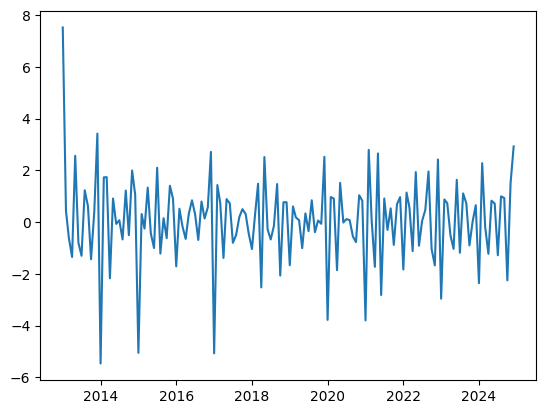

In [ ]:
plt.plot(data.index, data['Z-score'])

In [ ]:
  # vars=pd.concat([y,x], axis=1)
# vars
y.index=x.index
z=pd.concat([x,y], axis=1)
z.astype(float)

,Inflow (trade),Inflow (non-trade),Outflow (trade),Outflow (non-trade),Reserve position in the IMF,Foreign Exchange Reserves,Government’s net domestic assets (million AMD),Banks’ net domestic assets (million AMD),Net other assets (million AMD),CPI,...,Consumer loans loans,Mortgage loans,Others loans,Transport and communications loans (fc),Mortgage loans (fc),bitcoin_price,Dolarisation_avg,Gov. bond yealds,fc-loans,Z-score
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,11826.68,33862.69,15899.23,8403.41,31.817898,1736.221600,-130755.122057,175166.317124,191825.191936,0.007731,...,0.016509,-8.361170e-04,10917.020328,32666.773688,62998.863526,15.000000,0.013928,12.335275,891263.687361,7.521965
2013-02-01,7332.97,8210.63,1565.86,1329.16,21.638079,13.721772,8784.708717,-7144.944087,11991.905376,-0.032008,...,0.007990,-3.522740e-05,443.378554,561.564889,64452.406933,25.000000,-0.021937,11.872312,25180.900111,0.429852
2013-03-01,-3197.75,7165.59,-1877.86,912.39,1.650734,-120.376184,17477.634089,-14956.803026,-5716.027709,0.008236,...,0.040489,1.274980e-03,449.698689,1234.427285,67016.688425,60.000000,0.016117,-0.083237,-26975.933163,-0.614530
2013-04-01,5114.83,5428.33,1763.01,1442.81,13.734087,-5.115828,-525.131654,34360.739424,8304.680643,-0.005153,...,0.022991,3.834620e-04,-392.725488,-338.434759,66225.477979,139.000000,-0.017397,-0.221275,-5167.004804,-1.349483
2013-05-01,-6452.27,3755.59,1658.06,-1599.29,34.359215,10.891774,4855.041315,-4500.227729,8976.615989,0.000654,...,0.015826,-3.168855e-06,-302.921989,1830.300284,4955.669126,129.000000,0.015284,-1.102054,15844.272148,2.562559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,24925.65,554.09,77912.11,-1556.86,13.475149,187.925419,2617.704885,27185.359100,-7652.661133,0.004633,...,0.023861,3.354004e-04,-1072.640564,1951.464976,-3781.283871,-12363.749560,0.012895,-0.028073,95920.264544,0.994868
2024-09-01,-56829.70,-1521.70,-82302.54,-1235.03,9.227394,-26.671386,-16101.726421,172820.045148,-12042.863691,0.000839,...,0.025566,-4.624434e-07,3103.909994,7100.521535,-3605.958307,2692.641349,0.001082,0.138800,56721.469969,0.930966
2024-10-01,60900.61,-939.55,33078.52,2565.81,9.081365,17.315612,62860.027044,-236751.305851,-1405.180998,0.001199,...,0.024482,4.086000e-04,1423.146486,15010.185672,-1479.566400,2725.573856,-0.012822,0.011300,13870.530043,-2.251795


## **Applying ridge and lasso regressions for non lagged factors**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(x)
x_s=pd.DataFrame(scaled, columns=x.columns.values)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LassoCV
# Create and fit the Group Lasso model
# Define a range of alpha values in log space
alphas = np.logspace(-4, 1, 50)  # From 0.0001 to 10

tscv = TimeSeriesSplit(n_splits=5)  # 5 sequential splits

# Fit LassoCV with time-aware CV
lasso_cv = LassoCV(alphas=alphas, cv=tscv, random_state=43).fit(x_s, y)

# Best alpha value
print("Best alpha:", lasso_cv.alpha_)
lasso_coefs = lasso_cv.coef_


# Best alpha value
print("Best alpha:", lasso_cv.alpha_)

Best alpha: 0.11513953993264481
Best alpha: 0.11513953993264481


In [ ]:
from decimal import Decimal
lasso_eval_l=pd.DataFrame({"var_name": x.columns.values, "lasso_coef":lasso_coefs})

#CV=4
lasso_remove_l=lasso_eval_l['var_name'][lasso_eval_l['lasso_coef']==0].values
lasso_remove_l
lasso_eval_l['lasso_coef']=lasso_eval_l['lasso_coef'].apply(lambda i: Decimal(i) )

In [ ]:
print(len(lasso_eval_l))
print(len(lasso_remove_l))

44
30


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Define alpha values for Ridge regularization
alphas = np.logspace(-4, 4, 50)  # 0.0001 to 10,000

# Standardize features

# Define TimeSeriesSplit for time-aware CV
tscv = TimeSeriesSplit(n_splits=5)

# Store results
alpha_scores = {}

# Loop over different alphas to find the best one
for alpha in alphas:
    scores = []

    # TimeSeries CV evaluation
    for train_idx, test_idx in tscv.split(x_s):
        X_train, X_test = x_s.iloc[train_idx], x_s.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Train Ridge regression
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train, y_train)

        # Predict on validation set
        y_pred = ridge.predict(X_test)

        # Evaluate performance
        score = r2_score(y_test, y_pred)
        scores.append(score)

    # Store the average R² score for this alpha
    alpha_scores[alpha] = np.mean(scores)

# Select the best alpha
best_alpha = max(alpha_scores, key=alpha_scores.get)
print("Best Alpha:", best_alpha)

# Train final Ridge model with the best alpha
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(x_s, y)

# Evaluate on the full dataset (or separate test set)
y_pred = ridge_best.predict(x_s)

# Compute evaluation metrics
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)

print("Final Model Evaluation:")
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Inspect coefficients
ridge_coef = ridge_best.coef_
ridge_df_2 = pd.DataFrame({'factors': x_s.columns.values, 'score': ridge_coef})
print(ridge_df_2)

Best Alpha: 24.420530945486497
Final Model Evaluation:
R² Score: 0.7751
MSE: 0.6181
RMSE: 0.7862
MAE: 0.6188
                                              factors     score
0                                      Inflow (trade)  0.039167
1                                  Inflow (non-trade)  0.310316
2                                     Outflow (trade) -0.062431
3                                 Outflow (non-trade)  0.157159
4                         Reserve position in the IMF -0.008877
5                           Foreign Exchange Reserves  0.388608
6      Government’s net domestic assets (million AMD)  0.114266
7            Banks’ net domestic assets (million AMD)  0.442409
8                      Net other assets (million AMD)  0.027823
9                                                 CPI -0.037282
10                                       CPI-Services -0.111951
11                            Economic activity index -0.032588
12  Inv. comp. Sales and purchase transactions (mi...  0.02

In [ ]:
# len(x_ls.columns.values)


In [ ]:
ridge_df_2.sort_values(by='score')
ridge_significant_l=ridge_df_2[abs(ridge_df_2['score'])>0.05]
ridge_insignificant_l=ridge_df_2[abs(ridge_df_2['score'])<=0.05]
#0.001 is good


In [ ]:
# ridge_insignificant_l

In [ ]:
print(len(ridge_df_2))
print(len(ridge_insignificant_l))

44
16


In [ ]:
# ridge_significant_l

In [ ]:
# corr=pd.concat([x_ls,y_ls],axis=1).corr()
# y_corr_l=corr[['Z-score']].iloc[1:]


In [ ]:
# # corr_l=all_and_lagged_s.astype(float).corr()
# # y_corr_l=corr_l[['Z-score']]
# # y_corr=y_corr.transpose()
# y_corr_l
# len(y_corr_l)

In [ ]:
# y_corr_l

In [ ]:
# #selecting only hoghly correlated ones
# highly_correlated_l=y_corr_l[abs(y_corr_l['Z-score'])>=0.01]
# low_correlated_l=y_corr_l[(abs(y_corr_l['Z-score'])<0.01) ]
# #highly_correlated.to_csv('correlation4.csv')
# len(highly_correlated_l)

In [ ]:
l1=[i for i in lasso_remove_l]
l2=[i for i in ridge_insignificant_l['factors'].values]
# l3=[i for i in low_correlated_l.index.values]

# # Step 4: Convert the DataFrame back into a single list
combined_list = l1 + l2 #+ l3

# Step 3: Convert the combined list to a set to remove duplicates
to_remove = list(set(combined_list))
len(to_remove)

30

In [ ]:
#we remove factors needed to be removed from x
#const is also removed, so we need to add constant again
x_f=x[[i for i in x.columns.values if i not in to_remove]]

In [ ]:
# x_ls.columns.values

In [ ]:
len(x_f.columns.values)

14

#Evaluation of the model

In [ ]:
X=x_f

##Adding seasonal components

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

# Step 1: Perform Seasonal Decomposition
decomposed = seasonal_decompose(y, period=12, model='additive')
# data['seasonal_component'] = decomposed.seasonal
# data['trend_component'] = decomposed.trend
# data['residual_component'] = decomposed.resid  # The stationary part
y_seasonal = decomposed.seasonal
y_trend = decomposed.trend
y_residual = decomposed.resid

In [ ]:
# X['seasonal']=y_seasonal
# X['trend']=y_trend
# X['resid']=y_residual

##Train/test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=26, shuffle=False)
# Create and train the linear regression model


##Scaling

In [ ]:
import numpy as np
X_train_mean = X_train.mean(axis=0)  # Shape: (n_features,)
X_train_std = X_train.std(axis=0, ddof=1)  # Shape: (n_features,)
X_train_scaled=(X_train-X_train_mean)/X_train_std
X_test_scaled=(X_test-X_train_mean)/X_train_std

Y_train_mean=np.mean(Y_train)
Y_train_std=np.std(Y_train)

Y_train_scaled=(Y_train-Y_train_mean)/Y_train_std
Y_test_scaled=(Y_test-Y_train_mean)/Y_train_std

In [ ]:
Y_train_scaled=Y_train_scaled['Z-score']

##Adding time related factors

In [ ]:

a=pd.to_datetime(X_train_scaled.index)
a
X_train_scaled['month'] =a.month
#X_train_scaled['quarter'] = a.quarter
#X_train_scaled['year'] = a.year
X_train_scaled['month_sin'] =np.sin(2 * np.pi * a.month / 12)
#X_train_scaled['month_cos'] =np.cos(2 * np.pi * X_train_scaled['month'] / 12)

In [ ]:

b=pd.to_datetime(X_test_scaled.index)
b
X_test_scaled['month'] =b.month
#X_test_scaled['quarter'] = b.quarter
#X_test_scaled['year'] = b.year
X_test_scaled['month_sin'] =np.sin(2 * np.pi * b.month / 12)
#X_test_scaled['month_cos'] =np.cos(2 * np.pi * X_test_scaled['month'] / 12)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from torch.utils.data import Dataset, DataLoader


##1D CNN model specification

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools

# Function to create sequences
def create_sequences(data, target, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(target[i+time_steps])
    return np.array(X), np.array(y)


##grid search

In [ ]:
# from keras.models import Sequential
# from keras.layers import Conv1D, Dense, Flatten
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping
# from sklearn.metrics import mean_squared_error
# import numpy as np
# import itertools

# # Function to create sequences
# def create_sequences(data, target, time_steps):
#     X, y = [], []
#     for i in range(len(data) - time_steps):
#         X.append(data[i:i+time_steps])
#         y.append(target[i+time_steps])
#     return np.array(X), np.array(y)

# # Hyperparameter options
# window_sizes = [3,5, 6,8,12]
# filters_list = [8, 16, 32]
# dense_units_list = [10, 20, 30,40,50]
# learning_rates = [0.001, 0.005, 0.01]

# best_mse = float('inf')
# best_params = None

# results = []

# for window_size, filters, dense_units, lr in itertools.product(window_sizes, filters_list, dense_units_list, learning_rates):

#     # Create sequences
#     X_seq, y_seq = create_sequences(X_train_scaled, Y_train_scaled, time_steps=window_size)

#     if len(X_seq) < 10:  # Skip very small result
#         continue

#     # Train/validation split
#     val_split = int(len(X_seq) * 0.85)
#     X_train, X_val = X_seq[:val_split], X_seq[val_split:]
#     y_train, y_val = y_seq[:val_split], y_seq[val_split:]

#     # Model
#     model = Sequential()
#     model.add(Conv1D(filters=filters, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
#     model.add(Flatten())
#     model.add(Dense(dense_units, activation='relu'))
#     model.add(Dense(1))

#     model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

#     early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#     history = model.fit(X_train, y_train,
#                         validation_data=(X_val, y_val),
#                         epochs=50,
#                         batch_size=8,
#                         callbacks=[early_stop],
#                         verbose=0,
#                         shuffle=False)

#     # Evaluate
#     val_mse = model.evaluate(X_val, y_val, verbose=0)
#     results.append((val_mse, window_size, filters, dense_units, lr))

#     if val_mse < best_mse:
#         best_mse = val_mse
#         best_params = (window_size, filters, dense_units, lr)

# print("\nBest MSE:", best_mse)
# print("Best Params: window_size={}, filters={}, dense_units={}, lr={}".format(*best_params))


In [ ]:
best_params=(3, 32, 40, 0.01)


In [ ]:
Y_test_scaled=Y_test_scaled['Z-score']

In [ ]:

type(Y_test_scaled)

pandas.core.series.Series

##Custom model based on best hyperparams

In [ ]:
len(X_test_scaled)

15

In [ ]:

import os
import random
import numpy as np
import tensorflow as tf

os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
# Unpack best parameters
best_window, best_filters, best_dense, best_lr =(3, 16, 50, 0.01)

# Create test sequences
#X_test_seq, y_test_seq = create_sequences(X_test_scaled, Y_test_scaled, time_steps=best_window)

# Recreate train sequences with best window size
X_seq, y_seq = create_sequences(X_train_scaled, Y_train_scaled, time_steps=best_window)
val_split = int(len(X_seq) * 0.85)
X_train, X_val = X_seq[:val_split], X_seq[val_split:]
y_train, y_val = y_seq[:val_split], y_seq[val_split:]

# Rebuild and train best model
best_model = Sequential()
best_model.add(Conv1D(filters=best_filters, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
best_model.add(Flatten())
best_model.add(Dense(best_dense, activation='relu'))
best_model.add(Dense(1))

best_model.compile(optimizer=Adam(learning_rate=best_lr), loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

best_model.fit(X_train, y_train,
               validation_data=(X_val, y_val),
               epochs=50,
               batch_size=16,
               callbacks=[early_stop],
               shuffle=False,
               verbose=0)


In [ ]:
# Best Params: window_size=9, filters=8, dense_units=50, lr=0.01

X_test_seq, y_test_seq = create_sequences(X_test_scaled, Y_test_scaled, time_steps=best_params[0])

y_pred = best_model.predict(X_test_seq)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step


In [ ]:
# Y_test_scaled=Y_test_scaled['Z-score']

In [ ]:
y_test_seq.shape

(12,)

In [ ]:
X_test_seq.shape

(12, 3, 16)

##Model evaluation

In [ ]:
# Assuming you already created X_test_seq, y_test_seq using same time_steps

# Flatten
y_test_flat = y_test_seq.flatten()
y_pred_flat = y_pred.flatten()

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_test_flat, y_pred_flat)
mse = mean_squared_error(y_test_flat, y_pred_flat)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_flat, y_pred)

final_r2 = r2_score(y_test_flat, y_pred_flat)

print('Forecast Accuracy Metrics:')
print(f"Final Model R² Score: {final_r2:.4f}")

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

Forecast Accuracy Metrics:
Final Model R² Score: 0.8163
MAE: 0.3518924715742357
MSE: 0.17580858694431553
RMSE: 0.41929534572221944
MAPE: 0.7144568364803554


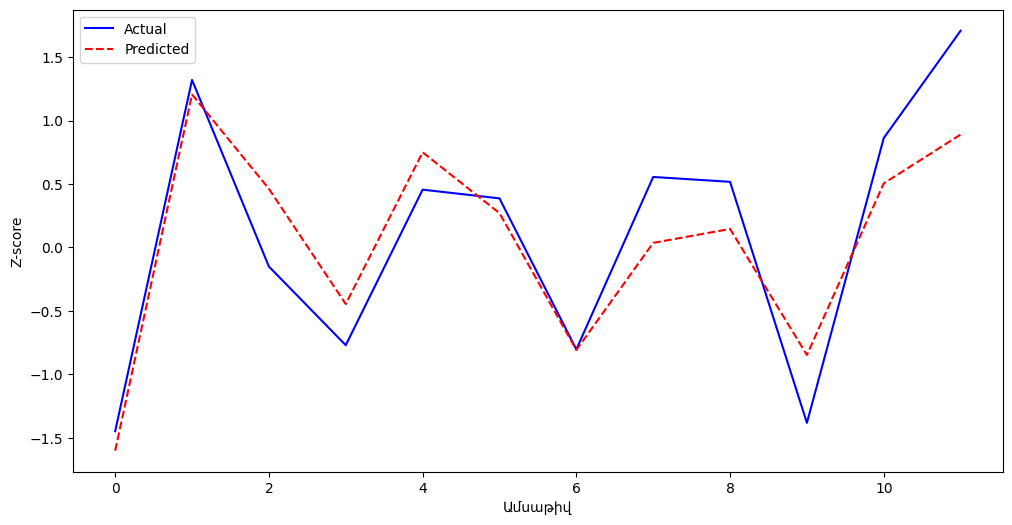

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_flat, label='Actual', linestyle='-', color='blue')
plt.plot(y_pred_flat, label='Predicted', linestyle='--', color='red')
plt.xlabel('Ամսաթիվ')
plt.ylabel('Z-score')
# plt.title('1D CNN - Actual vs Predicted')
plt.legend()
plt.show()


##Recovering original scale

In [ ]:
y_pred_stationary = y_pred_flat
y_pred_stationary = [i*Y_train_std+Y_train_mean for i in y_pred_stationary]

In [ ]:
Y_train_original=y_back['Z-score'][:-12]
Y_train_original

,Z-score
Date,
2013-01-01,7.521965
2013-02-01,7.951818
2013-03-01,7.337288
2013-04-01,5.987805
2013-05-01,8.550364
...,...
2023-08-01,7.571642
2023-09-01,8.296432
2023-10-01,7.393699


In [ ]:
first_elem=Y_train_original.iloc[-1]+y_pred_stationary[0]
new=[]
new.append(first_elem)
for i in range(1,len(y_pred_stationary)):
  new.append(y_pred_stationary[i]+new[i-1])


# elems=[train_pred.iloc[i]+train_pred.iloc[i-1] for i in range(1,len(train_pred))]
# elems.insert(0,first_elem)
# len(elems)
# rec=pd.DataFrame(elems, index=y_back.index[-14:], columns=['Z-score'])

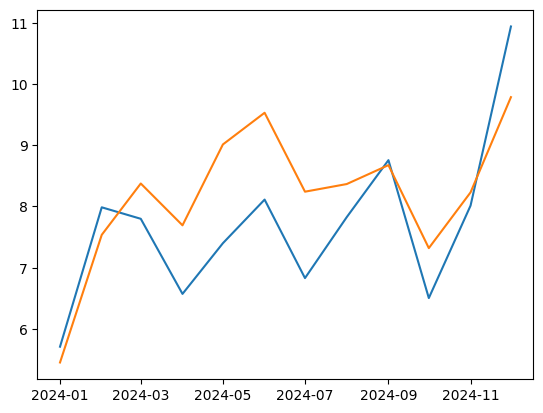

In [ ]:
new=pd.Series(new,index=y_back.index[-12:])
plt.plot(y_back[-12:])
plt.plot(new)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_back[-12:], new)
mse = mean_squared_error(y_back[-12:], new)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_back[-12:], new)
r2 = r2_score(y_back[-12:], new)

print('Forecast Accuracy Metrics:')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f"R^2 Score: {r2}")
# Interpretation:

Forecast Accuracy Metrics:
MAE: 0.8044541171153933
MSE: 0.9000331046912247
RMSE: 0.9487007455943232
MAPE: 0.10678107733716585
R^2 Score: 0.44583047919509045


##Calculating Feature importance metrics

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
                                              Feature  Importance
0            Banks’ net domestic assets (million AMD)    0.725189
1                                        CPI-Services    0.041842
2                                  Inflow (non-trade)    0.038383
3                                   Return on capital    0.018957
4                Demand 

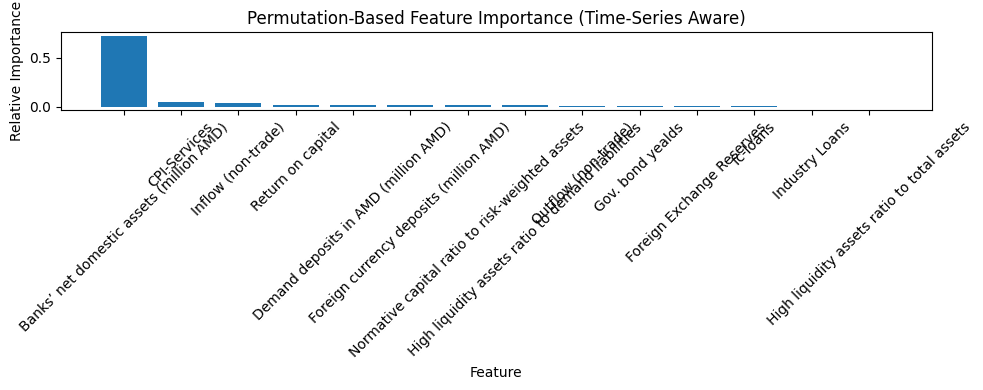

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assume:
# X_test_seq: shape (n_sequences, sequence_length, n_features)
# y_test_seq: shape (n_sequences,)
# best_model: trained 1D CNN model
# X_test: DataFrame with feature names (optional)

# Get feature names
feature_names = list(X_test.columns.values) if isinstance(X_test, pd.DataFrame) else [f'feature_{i}' for i in range(X_test_seq.shape[2])]

# 1. Baseline prediction
baseline_preds = best_model.predict(X_test_seq)
baseline_mse = mean_squared_error(y_test_seq, baseline_preds)

importances = []

# 2. Loop over features
for feature_idx in range(X_test_seq.shape[2]):
    X_permuted = X_test_seq.copy()

    # 3. Shuffle across samples for each time step, preserving sequence structure
    for t in range(X_test_seq.shape[1]):  # loop through time steps
        temp = X_permuted[:, t, feature_idx].copy()
        np.random.shuffle(temp)
        X_permuted[:, t, feature_idx] = temp

    # 4. Predict with permuted feature
    permuted_preds = best_model.predict(X_permuted)
    permuted_mse = mean_squared_error(y_test_seq, permuted_preds)
    importances.append(permuted_mse - baseline_mse)

# 5. Normalize importances
importances = np.array(importances)
normalized_importances = importances / np.sum(importances)

# 6. Format output
importance_dict = dict(zip(feature_names, normalized_importances))
importance_dict = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))
importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])

# 7. Display results
print(importance_df)

# 8. Plot results
plt.figure(figsize=(10, 4))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.title("Permutation-Based Feature Importance (Time-Series Aware)")
plt.xlabel("Feature")
plt.ylabel("Relative Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# importance_df.to_csv('/content/drive/My Drive/Dissertation/best_importance_1d_nn.csv')